In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [107]:
!pip install -U scikit-learn

In [108]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [109]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File ‘sp500sub.csv’ already there; not retrieving.



In [110]:
df0 = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)

In [111]:
df = df0[df0['Name'] == 'SBUX'][['Close']].copy()

In [112]:
df['LogClose'] = np.log(df['Close'])

In [113]:
df['DiffLogClose'] = df['LogClose'].diff()

In [114]:
Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [115]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['DiffLogClose']])
test_scaled = scaler.transform(test[['DiffLogClose']])

In [116]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [117]:
df.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

In [118]:
# Make supervised dataset
series = df['ScaledLogReturn'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2252, 10) Y.shape (2252,)


In [119]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [120]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [121]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [122]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=200,
  validation_data=(Xtest, Ytest)
)

Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5424 - val_loss: 1.1196
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2243 - val_loss: 0.9776
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1485 - val_loss: 0.9249
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1186 - val_loss: 0.9059
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1036 - val_loss: 0.9014
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0942 - val_loss: 0.9031
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0875 - val_loss: 0.9077
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0821 - val_loss: 0.9136
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0776 - val_loss: 0.9200
Epoch 10/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0737 - val_loss: 0.9269
Epoch 11/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0703 - val_loss: 0.9324
Epoch 12/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1

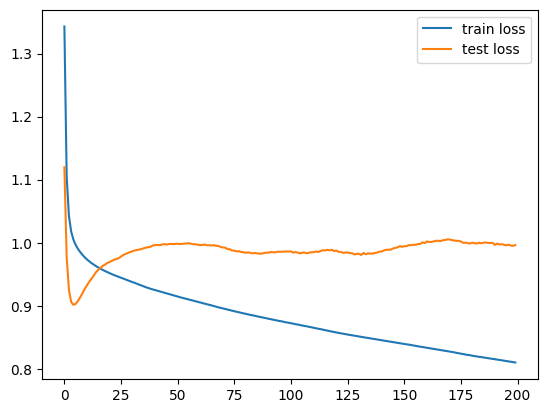

In [123]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [124]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [125]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [126]:
# Store diff predictions
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

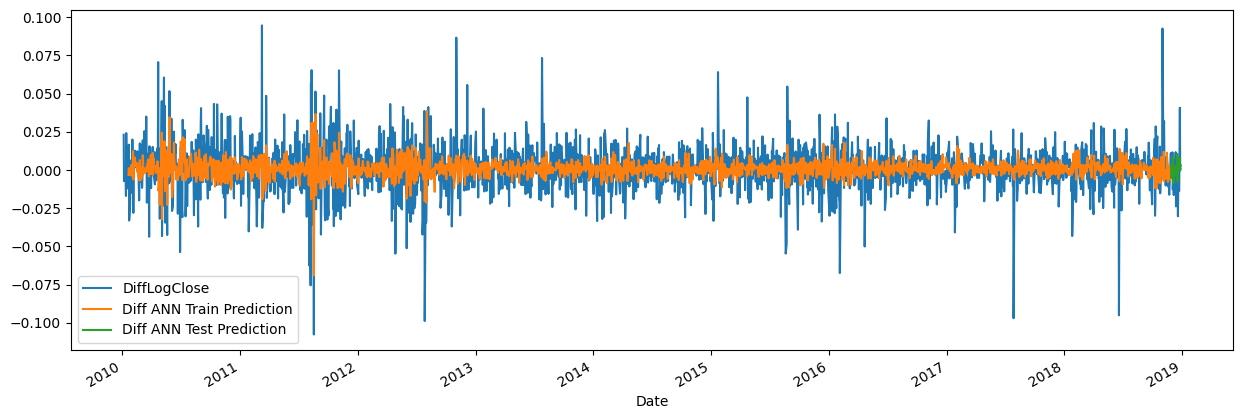

In [127]:
cols = ['DiffLogClose',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction']
df[cols].plot(figsize=(15, 5));

In [128]:
# Needed to compute un-differenced predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

In [129]:
# Last-known train value
last_train = train.iloc[-1]['LogClose']

In [130]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

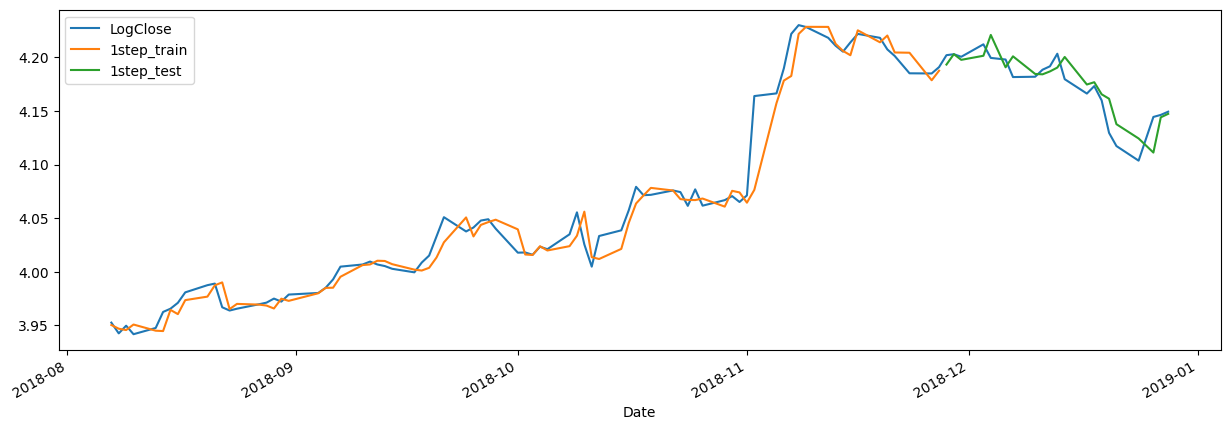

In [131]:
# plot 1-step forecast
df.iloc[-100:][['LogClose', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [132]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipython-input-692323302.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_x[-1] = p


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


In [133]:
# unscale
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(
    multistep_predictions.reshape(-1, 1)).flatten()

In [134]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

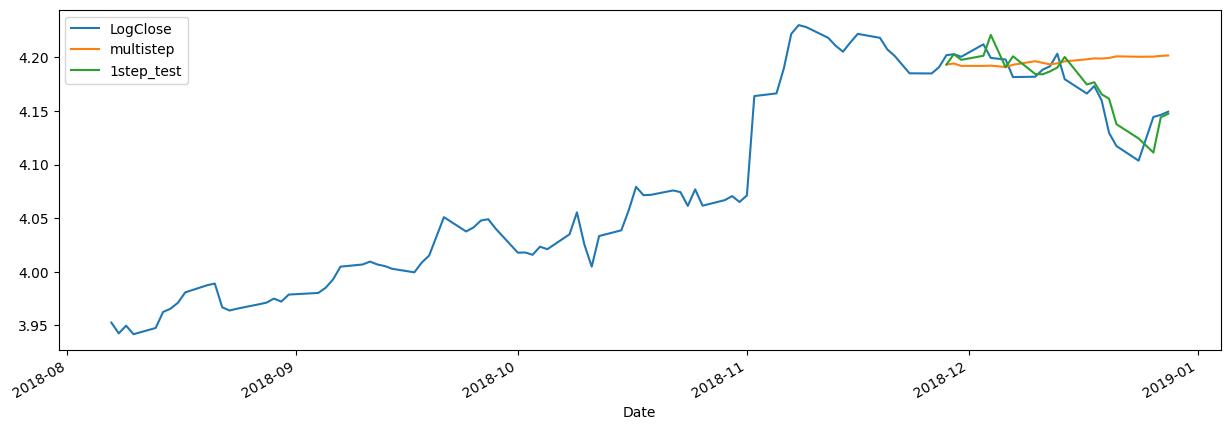

In [135]:
# plot 1-step and multi-step forecast
df.iloc[-100:][['LogClose', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [136]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2232, 10) Y.shape (2232, 21)


In [137]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [138]:
# Basic ANN
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i, x)

In [139]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [140]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=100,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2134 - val_loss: 1.0902
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0793 - val_loss: 1.0508
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0415 - val_loss: 1.0361
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0229 - val_loss: 1.0301
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0123 - val_loss: 1.0278
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0056 - val_loss: 1.0277
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0010 - val_loss: 1.0302
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9976 - val_loss: 1.0320
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9951 - val_loss: 1.0332
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9930 - val_loss: 1.0338
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9913 - val_loss: 1.0340
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

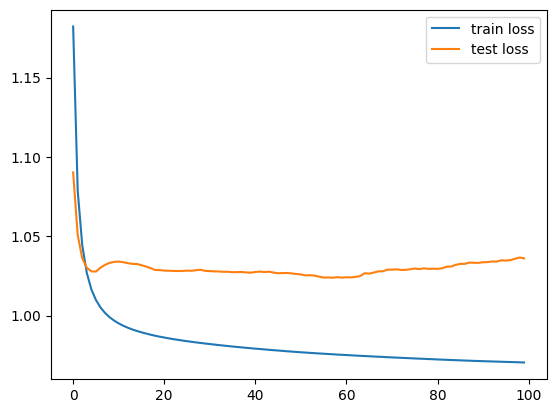

In [141]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [142]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [143]:
Ptrain.shape, Ptest.shape

((2231, 21), (21, 21))

In [144]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [145]:
# unscale
Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()

In [146]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

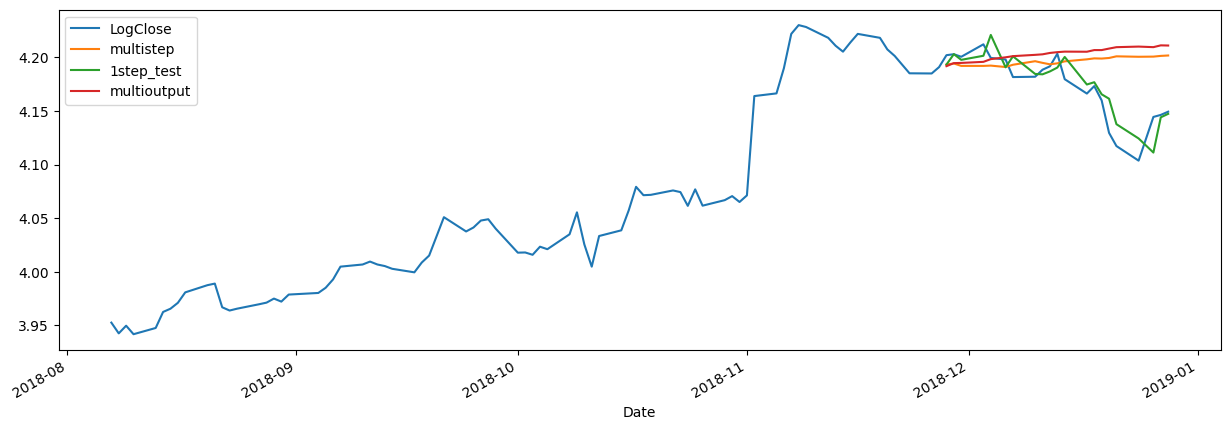

In [147]:
# plot all forecasts
cols = ['LogClose', 'multistep', '1step_test', 'multioutput']
df.iloc[-100:][cols].plot(figsize=(15, 5));

In [148]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogClose']
mape0 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, '1step_test'])
print("1step_test MAPE:", mape0)
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

1step_test MAPE: 0.002790773070835912
multi-step MAPE: 0.0072467508587104644
multi-output MAPE: 0.00834013622354613


In [149]:
# 1-step Binary Classification

In [150]:
Ytrain_b = (Ytrain > 0) * 1
Ytest_b = (Ytest > 0) * 1

In [151]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [152]:
model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # because in final layer we didn't apply sigmoid because exponential leads to unstable large numbers
  optimizer='adam',
  metrics=['accuracy'],
)

In [153]:
r = model.fit(
  Xtrain,
  Ytrain_b,
  epochs=100,
  validation_data=(Xtest, Ytest_b)
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4877 - loss: 0.7262 - val_accuracy: 0.5238 - val_loss: 0.6596
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4927 - loss: 0.6996 - val_accuracy: 0.5238 - val_loss: 0.6719
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4953 - loss: 0.6930 - val_accuracy: 0.5238 - val_loss: 0.6782
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4946 - loss: 0.6899 - val_accuracy: 0.5238 - val_loss: 0.6806
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4944 - loss: 0.6880 - val_accuracy: 0.5238 - val_loss: 0.6808
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4938 - loss: 0.6867 - val_accuracy: 0.5238 - val_loss: 0.6799
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4943 - loss: 0.6856 - val_accuracy: 0.5238 - val_loss: 0.6785
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4953 - loss: 0.6846 - val_accuracy: 0.5238 - v

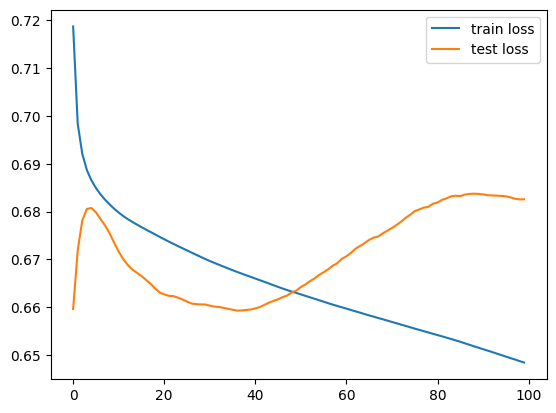

In [154]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

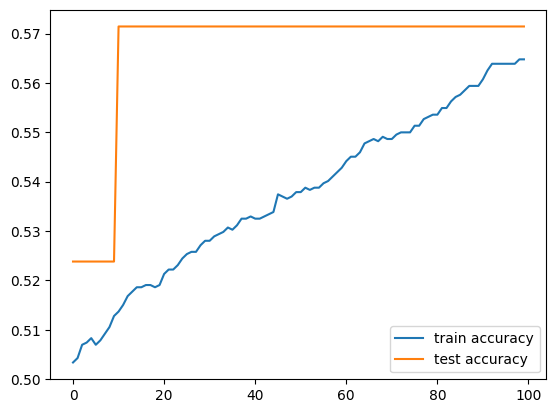

In [155]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend();

In [156]:
# Exercise:
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?
# What is a better metric?